# DCGANs (Deep Convolutional Generative Adversarial Networks)

### Ejercicio 2: DCGANs

Construir un modelo DCGAN que pueda generar emoticons de un tamaño de 40x40.

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# Device configuration (GPU o CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Dataset

Usaremos el dataset de emojis. Este dataset contiene imágenes de emoticons de diferentes categorías: `Apple`, `Facebook`, `Google`, `HTC`, `Joy`, `Instagram`, `Microsoft`, `Samsung`, `Softbank` y `Twitter`.

El dataset lo podemos encontrar en el siguiente enlace: https://www.kaggle.com/datasets/singlecyclecomputer/emojis 

Las imágenes del dataset están en formato JPG y tienen un tamaño de 72x72 píxeles pero nosotros vamos a trabajar con imágenes de 48x48 píxeles para que el entrenamiento sea más rápido.

In [2]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, num_transforms=5):
        self.dataset = ImageFolder(root=root)
        self.transform = transform
        self.num_transforms = num_transforms
        self.classes = ('Apple', 'Facebook', 'Google', 'HTC', 'Joy', 'Instagram', 'Microsoft', 'Samsung', 'Softbank', 'Twitter')

    def __len__(self):
        return len(self.dataset) * self.num_transforms

    def __getitem__(self, idx):
        original_idx = idx // self.num_transforms # dividimos por el número de transformaciones para obtener el índice original
        image, label = self.dataset[original_idx] # obtenemos la imagen y la etiqueta original
        # aplicamos la transformación
        if self.transform:
            transformed_image = self.transform(image) # aplicamos la transformación
        else: # si no hay transformación, devolvemos la imagen original
            transformed_image = image
            
        return transformed_image, label

In [3]:
# Ruta donde se almacenarán los datos Emojis
root = 'datasets/emojis/'

# Transformación de las imágenes
transform = transforms.Compose([
    transforms.RandomRotation(25), # Rotación aleatoria de 25 grados
    transforms.RandomHorizontalFlip(p=0.5), # Volteo horizontal con probabilidad de 0.5
    transforms.RandomCrop(64, padding=4, padding_mode='reflect'), # Recorte aleatorio de 64x64 con relleno de 4 pixeles
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # Traslación aleatoria de 0.1
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2), # Cambio aleatorio de brillo, contraste, saturación y tono
    transforms.Resize((48, 48)), # Redimensionamos a 48x48
    transforms.ToTensor(), # Convertimos a tensor
    transforms.Lambda(lambda x: x * 2. - 1.) # Normalizamos a [-1, 1]
])
# Creamos el dataset personalizado con las transformaciones anteriores y 10 transformaciones por imagen
custom_dataset = CustomDataset(root=root, transform=transform, num_transforms=10)

Cargamos a un dataloader las imágenes del dataset para poder trabajar con ellas.

In [4]:
dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=64, shuffle=True)
imgs, _ = next(iter(dataloader))
imgs.shape, imgs.dtype, imgs.min(), imgs.max()

c:\Users\israe\anaconda3\envs\cuda_user\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


(torch.Size([64, 3, 48, 48]), torch.float32, tensor(-1.), tensor(1.))

In [5]:
# tamaño del dataset
len(custom_dataset)

8640

Mostramos algunas imágenes del dataset para ver cómo son las imágenes.

c:\Users\israe\anaconda3\envs\cuda_user\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


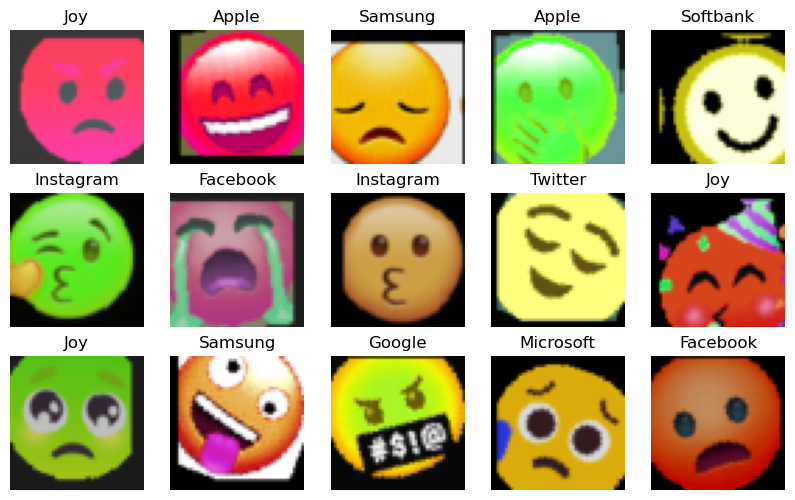

In [6]:
import random
import matplotlib.pyplot as plt

# Crear un iterador para el DataLoader
data_iter = iter(dataloader)
# Crear una figura con subtramas de 3 filas y 5 columnas
fig, axs = plt.subplots(3, 5, figsize=(10, 6))
# Rellenar las subtramas con imágenes del DataLoader
for i in range(3):
    for j in range(5):
        # Obtener un lote de datos del DataLoader
        images, labels = next(data_iter)
        # Seleccionar una imagen aleatoria del lote
        random_index = random.randint(0, 64 - 1)
        img, lab = images[random_index], labels[random_index]
        # Desnormalizar la imagen (revertir la normalización que se hizo en la transformación)
        img = (img.permute(1, 2, 0) + 1) / 2.0
        # Mostrar la imagen en la subtrama
        axs[i, j].imshow(img)
        axs[i, j].set_title(custom_dataset.classes[lab.item()])
        axs[i, j].axis('off')
plt.show()

### Generador

El generador es una red neuronal convolucional que toma como entrada un vector de ruido y genera una imagen de 48x48 píxeles.

Usaremos diferentes funciones, explicaremos cada una de ellas:

- `BatchNorm2d`: Normaliza los datos de entrada por batch.
- `Upsample`: Aumenta el tamaño de la imagen.
- `LeakyReLU`: Función de activación que permite que los gradientes fluyan hacia atrás a través de la capa en lugar de desvanecerse.
- `Conv2d`: Aplica una convolución 2D sobre la entrada.
- `Tanh`: Función de activación que comprime los valores entre -1 y 1.

In [111]:
import torch.nn as nn

class Generator2(nn.Module):
    def __init__(self, z_dim=100, img_channels=3):
        super(Generator2, self).__init__()
        self.init_size = 48 // 4  # Tamaño inicial después de la capa lineal
        self.input_size = z_dim # ruido de entrada
        self.img_channels = img_channels # canales de la imagen de salida
        # Capa lineal que mapea el ruido de entrada a una imagen de 128 canales con tamaño 12x12
        self.l1 = nn.Sequential(nn.Linear(self.input_size, 128 * self.init_size ** 2))
        # Bloques de convolución
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128), # Normalización por lotes
            nn.Upsample(scale_factor=2), # Upsampling de 12x12 a 24x24
            nn.Conv2d(128, 128, 3, stride=1, padding=1), # Convolución de 128 canales con kernel de 3x3, stride de 1 y padding de 1
            nn.BatchNorm2d(128), # Normalización por lotes
            nn.LeakyReLU(0.2, inplace=True), # LeakyReLU con pendiente de 0.2
            nn.Upsample(scale_factor=2), # Upsampling de 24x24 a 48x48
            nn.Conv2d(128, 64, 3, stride=1, padding=1), # Convolución de 64 canales con kernel de 3x3, stride de 1 y padding de 1
            nn.BatchNorm2d(64), # Normalización por lotes
            nn.LeakyReLU(0.2, inplace=True), # LeakyReLU con pendiente de 0.2
            nn.Conv2d(64, self.img_channels, 3, stride=1, padding=1), # Convolución de 3 canales con kernel de 3x3, stride de 1 y padding de 1
            nn.Tanh(), # Tanh para obtener valores entre [-1, 1]
        )

    def forward(self, z):
        out = self.l1(z) # Aplicamos la capa lineal
        out = out.view(out.shape[0], 128, self.init_size, self.init_size) # Redimensionamos 
        img = self.conv_blocks(out) # Aplicamos los bloques de convolución para obtener la imagen
        img = img.view(img.size(0), self.img_channels*48*48) # Redimensionamos a un vector de 6912 elementos
        return img
    
generator2 = Generator2(z_dim=100, img_channels=3)
output = generator2(torch.randn(64, 100))
output.shape

torch.Size([64, 6912])

### Discriminador

El discriminador es una red neuronal convolucional que toma como entrada una imagen de 48x48 píxeles y devuelve un valor entre 0 y 1 que indica si la imagen es real o falsa.

Usaremos diferentes funciones, explicaremos cada una de ellas:
- `BatchNorm2d`: Normaliza los datos de entrada por batch.
- `LeakyReLU`: Función de activación que permite que los gradientes fluyan hacia atrás a través de la capa en lugar de desvanecerse.
- `Conv2d`: Aplica una convolución 2D sobre la entrada.
- `Sigmoid`: Función de activación que comprime los valores entre 0 y 1.

In [112]:
class Discriminator2(nn.Module):
    def __init__(self, img_channels=3):
        super(Discriminator2, self).__init__()
        self.img_channels = img_channels # canales de la imagen de entrada
        # Bloques de convolución para obtener un vector de 128 elementos a partir de una imagen de 48x48
        self.main = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=4, stride=2, padding=1, bias=False), # Convolución de 64 canales con kernel de 4x4, stride de 2 y padding de 1
            nn.BatchNorm2d(64), # Normalización por lotes
            nn.LeakyReLU(0.2, inplace=True), # LeakyReLU con pendiente de 0.2
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False), # Convolución de 128 canales con kernel de 4x4, stride de 2 y padding de 1
            nn.BatchNorm2d(128), # Normalización por lotes
            nn.LeakyReLU(0.2, inplace=True) # LeakyReLU con pendiente de 0.2
        )
        # Capa lineal que mapea el vector de 128 elementos a un valor entre 0 y 1
        self.out = nn.Sequential(
            nn.Linear(128 * 12 * 12, 1), # Capa lineal de 128*12*12 elementos a 1 elemento
            nn.Sigmoid() # Sigmoid para obtener valores entre 0 y 1
        )

    def forward(self, x):
        x = x.view(x.size(0), self.img_channels, 48, 48) # Redimensionamos a 48x48
        x = self.main(x) # Aplicamos los bloques de convolución
        x = x.view(x.size(0), -1) # Redimensionamos a un vector de 128*12*12 elementos
        x = self.out(x) # Aplicamos la capa lineal
        return x

discriminator2 = Discriminator2()
output = discriminator2(torch.randn(64, 3*48*48))
output.shape

torch.Size([64, 1])

### Función de entrenamiento

La función de entrenamiento es la encargada de entrenar el modelo. En esta función se calcula el error del discriminador y del generador y se actualizan los pesos de cada uno de ellos.

Para entrenar el modelo se siguen los siguientes pasos:
- Se generan imágenes falsas con el generador.
- Se calcula el error del discriminador con las imágenes reales y con las imágenes falsas.
- Se actualizan los pesos del `discriminador`.
- Se generan imágenes falsas con el generador.
- Se calcula el error del generador con las imágenes falsas.
- Se actualizan los pesos del `generador`.

In [293]:
import numpy as np
from fastprogress.fastprogress import master_bar, progress_bar

def fit2(g, d, dataloader, epochs=5, lr=3e-4):
    g.to(device)
    d.to(device)
    g_optimizer = torch.optim.Adam(g.parameters(), lr=lr)
    d_optimizer = torch.optim.Adam(d.parameters(), lr=lr)
    crit = nn.BCELoss()
    g_loss, d_loss = [], []
    mb = master_bar(range(1, epochs+1))
    hist = {'g_loss': [], 'd_loss': []}
    for epoch in mb:
        for X, y in progress_bar(dataloader, parent=mb):
            X, y = X.to(device), y.to(device)
            # entrenamos el discriminador
            g.eval()
            d.train()
            # generamos un batch de imágenes falsas
            noise = torch.randn((X.size(0), g.input_size)).to(device)
            genenerated_images = g(noise)
            # input del discrminator
            d_input = torch.cat([genenerated_images, X.view(X.size(0), -1)])
            # gorund truth para el discriminator
            d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1,1).to(device)
            # optimización
            d_optimizer.zero_grad()
            d_output = d(d_input)
            d_l = crit(d_output, d_gt)
            d_l.backward()
            d_optimizer.step()
            d_loss.append(d_l.item())
            # entrenamos el generador
            g.train()
            d.eval()
            # generamos un batch de imágenes falsas
            noise = torch.randn((X.size(0), g.input_size)).to(device)
            genenerated_images = g(noise)
            # salidas del discriminador
            d_output = d(genenerated_images)
            # gorund truth para el generator
            g_gt = torch.ones(X.size(0)).view(-1,1).to(device)
            # optimización
            g_optimizer.zero_grad()
            g_l = crit(d_output, g_gt)
            g_l.backward()
            g_optimizer.step()
            g_loss.append(g_l.item())
            # logs
            mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
        if epoch % 5 == 0:
            mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
        hist['g_loss'].append(np.mean(g_loss))
        hist['d_loss'].append(np.mean(d_loss))
        
        torch.save(g.state_dict(), 'models/generator_v1_5_' + str(epoch) + '.pth')
        torch.save(d.state_dict(), 'models/discriminator_v1_5_' + str(epoch) + '.pth')
    return hist

In [294]:
hist2 = fit2(generator2, discriminator2, dataloader, epochs=50, lr=4e-4)

c:\Users\israe\anaconda3\envs\cuda_user\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Mostramos algunas imágenes generadas por el modelo para ver la calidad de las imágenes generadas.

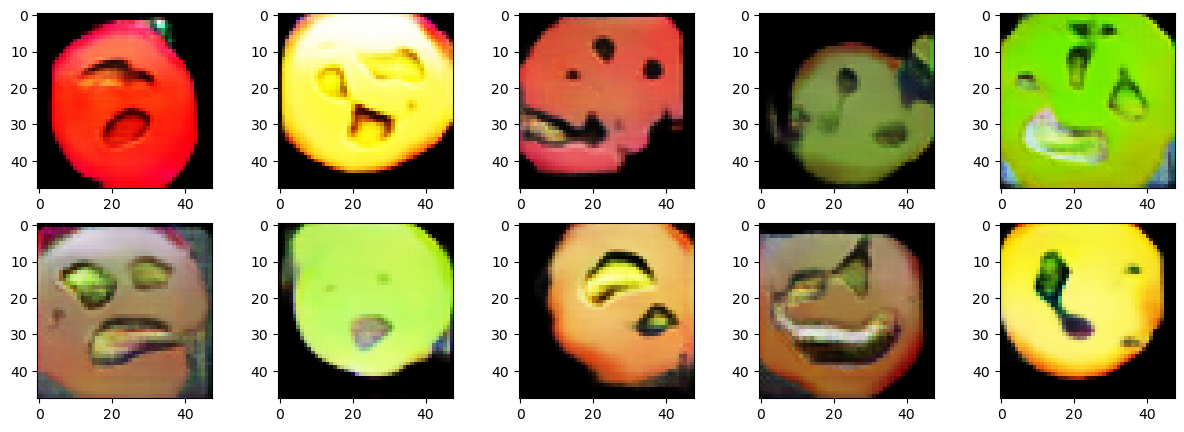

In [298]:
generator2.eval().to(device)
with torch.no_grad():
  noise = torch.randn((10, generator2.input_size)).to(device)
  generated_images = generator2(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,5))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = (generated_images[i].view(3,48,48).permute(1,2,0).cpu())*0.5+0.5
      _ax.imshow(img)
      i+=1
  plt.show()

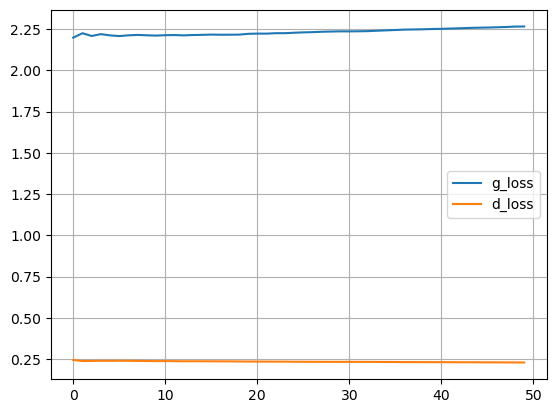

In [288]:
import pandas as pd

df = pd.DataFrame(hist2)
df.plot(grid=True)
plt.show()

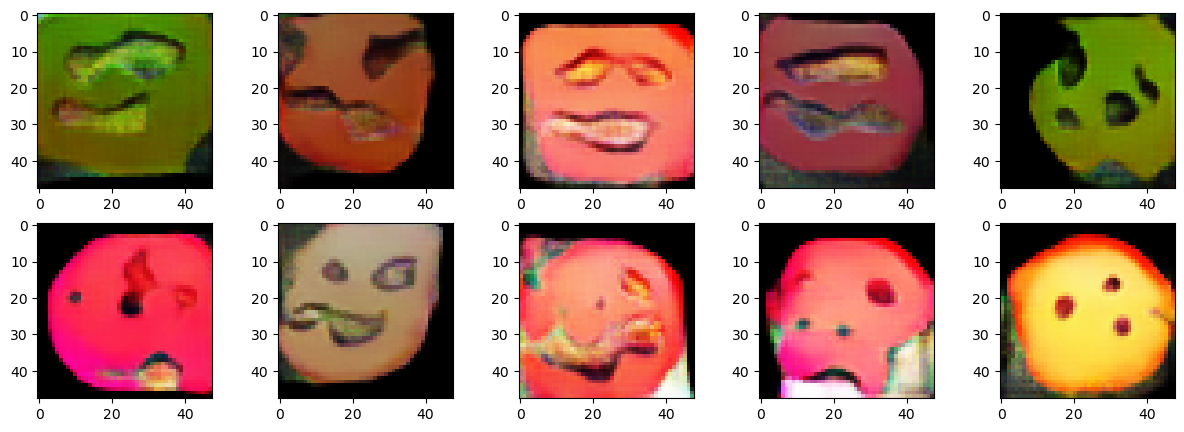

In [292]:
# cargar modelo entrenado
generator2 = Generator2(z_dim=100, img_channels=3)
generator2.load_state_dict(torch.load('models/generator_v1_4_50.pth'))
discriminator2 = Discriminator2()
discriminator2.load_state_dict(torch.load('models/discriminator_v1_4_50.pth'))
generator2.eval().to(device)
with torch.no_grad():
  noise = torch.randn((10, generator2.input_size)).to(device)
  generated_images = generator2(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,5))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = (generated_images[i].view(3,48,48).permute(1,2,0).cpu())*0.5+0.5
      _ax.imshow(img)
      i+=1
  plt.show()

### Conclusiones

En este ejercicio hemos construido un modelo DCGAN que puede generar emoticons de un tamaño de 48x48 píxeles, hemos entrenado el modelo y hemos mostrado algunas imágenes generadas por el modelo.

El proceso de entrenamiento ha sido por versiones y en cada versión hemos ido mejorando el modelo. En la versión 1 hemos entrenado el modelo con 20 epochs, con un lr=3e-4 y hemos obtenido imágenes con poca calidad. En la versión 2 hemos entrenado el modelo con 20 epochs, con un lr=3e-4 y hemos obtenido imágenes con mejor calidad. En la versión 3 hemos entrenado el modelo con 40 epochs, con un lr=1e-4 y hemos obtenido imágenes con mejor calidad. En la versión 4 hemos entrenado el modelo con 50 epochs, con un lr=7e-5 y hemos obtenido imágenes con mejor calidad. En la versión 5 hemos entrenado el modelo con 50 epochs, con un lr=1e-4 y hemos obtenido imágenes con mejor calidad.

En la versión 5 hemos obtenido las mejores imágenes generadas por el modelo, pero aún así las imágenes generadas por el modelo no son de muy buena calidad. Esto puede ser debido a que el dataset es pequeño y no contiene muchas imágenes. Si tuviéramos un dataset más grande con más imágenes de cada categoría, el modelo podría generar imágenes de mejor calidad.

En conclusion podemos decir que el modelo DCGAN es un modelo muy potente que puede generar imágenes de muy buena calidad, pero para ello necesitamos un dataset grande con muchas imágenes, ya que si el dataset es pequeño el modelo no podrá generar imágenes de buena calidad.